# 1 参数设定

In [113]:
import torch
import numpy as np


class Config():
    def __init__(self):
        self.mode = 'train' # train or test

        self.continue_train = False # 是否继续训练
        self.last_train_epoch = 0 # 上次训练的epoch


        # 数据的部分特征
        self.data_lable = 'bus'
        self.data_path = './sketch_datas/'
        self.data_labels_list = ['ambulance','apple','bear','bicycle','bird','bus','cat','foot','owl','pig']
        self.data_max = 400 # 每个类别的最大数据量,节省训练时间
        # self.full_length = 256 # 一条数据的完整长度
        self.N_max = 0 # 一条数据的最大长度，可修改
        self.lengths = [] # 一条数据的实际长度，可修改


        # 编码器的参数设置
        self.encoder_dim = 256 # encoder的输出维度
        self.z_dim = 128 # 中间向量Z的维度

        # 解码器的参数设置
        self.decoder_dim = 512 # decoder的输出维度
        self.M = 20 # GMM的分布数量

        # 训练参数
        if torch.cuda.is_available():
            self.device = 'cuda'
        elif torch.backends.mps.is_available():
            self.device = 'mps'
        else:
            self.device = 'cpu'

        self.grad_clip = 1.0 # 梯度裁剪
        self.batch_size = 100
        self.lr = 0.001
        self.epoch = 30 # 本次训练的epoch
        self.W_kl = 1 # kl损失的权重
        self.temperature = 0.0001 #温度参数


        # 测试参数
        self.test_epoch = self.epoch
        self.gen_num = 10 # 生成的数据数量
    

# 2 数据
读入数据，并对数据进行预处理
数据集由配置文件决定

In [114]:
import random
from re import split

def get_max(arr):
    return arr.shape[1]
    

# 按照ratios划分数据集
def split_data(arr, ratios):
    # 计算分割点
    total_length = arr.shape[0]
    splits = [int(total_length * ratio / sum(ratios)) for ratio in ratios]
    
    splits[-1] = total_length - sum(splits[:-1])

    # 按照分割点分割数组
    split_arrays = []
    start = 0
    for split in splits:
        split_arrays.append(arr[start:start + split])
        start += split

    return split_arrays

# 按照batch_size随机划分数据集
def split_in_batch(arr, config):
    # 划分batch，不足batchsize的直接丢弃
    batch_num = arr.shape[0] // config.batch_size 
    max_length = batch_num * config.batch_size # 最长有效数据长度

    # 打乱数据
    shuffled_arr = arr[:max_length].copy()
    np.random.shuffle(shuffled_arr)

    split_arrays = np.array(np.split(shuffled_arr, batch_num))

    return split_arrays


In [115]:
config = Config() # 初始化相关配置

# 加载数据
f_path = config.data_path + config.data_lable + '.npy'
f = np.load(f_path)[:config.data_max] 

# 随机选取数据
indices = np.random.choice(f.shape[0], size=config.data_max, replace=False)
arr = f[indices]

config.N_max = get_max(arr) # 获取最大长度，数据已补全
config.lengths = [config.N_max] * config.batch_size # 简单处理lengths列表

# 划分数据集
train_data, val_data, test_data = split_data(arr,[2,1,1])

# 划分batch
train_data = split_in_batch(train_data, config).astype(np.float32)
val_data = split_in_batch(val_data, config).astype(np.float32)
test_data = np.array(test_data).astype(np.float32) # test数据不用划分batch


print(config.data_lable, 'dataset is loaded')
print('N_max:',config.N_max,',data_type:', train_data.dtype,', batch_size:',config.batch_size)
print('train_data:',train_data.shape)
print('val_data:',val_data.shape)
print('test_data:',test_data.shape)


bus dataset is loaded
N_max: 147 ,data_type: float32 , batch_size: 100
train_data: (2, 100, 147, 5)
val_data: (1, 100, 147, 5)
test_data: (100, 147, 5)


# 3 模型搭建

In [116]:
import torch.nn as nn
import torch

# 2 

class encoderRNN(nn.Module):
    def __init__(self, config):
        super(encoderRNN, self).__init__()
        self.lstm = nn.LSTM(5, config.encoder_dim, bidirectional=True) # 双向lstm
        self.fc_mu = nn.Linear(config.encoder_dim*2, config.z_dim)
        self.fc_sigma = nn.Linear(config.encoder_dim*2, config.z_dim)


    def forward(self, config, input):
        h0 = torch.zeros(2, config.batch_size, config.encoder_dim).to(config.device)
        c0 = torch.zeros(2, config.batch_size, config.encoder_dim).to(config.device)
        hidden_cell = (h0, c0)

        outputs, (hidden, cell) = self.lstm(input, hidden_cell)

        # 完成编码，调整数据形状
        # (2, batch_size, hidden_size) -> (batch_size, 2*hidden_size)
        hidden_forward, hidden_backward = torch.split(hidden, 1, 0)
        hidden_cat = torch.cat([hidden_forward.squeeze(0), hidden_backward.squeeze(0)], 1)
        
        # mu部分
        mu = self.fc_mu(hidden_cat)

        # sigma部分
        sigma_hat = self.fc_sigma(hidden_cat)
        sigma = torch.exp(sigma_hat / 2.0)

        # gaussian noise
        N = torch.randn_like(mu)

        Z = mu + sigma * N


        return Z, mu, sigma_hat

# 2
class decoderRNN(nn.Module):
    def __init__(self, config):
        super(decoderRNN, self).__init__()
        self.N_max = config.N_max
        
        self.lstm = nn.LSTM(config.z_dim + 5, config.decoder_dim)
        self.fc_hc = nn.Linear(config.z_dim, 2 * config.decoder_dim)

        # 6M+3
        self.fc_output = nn.Linear(config.decoder_dim, 6 * config.M + 3)
        # self.fc_q = nn.Linear(config.decoder_dim, 3)
        

    def forward(self, config, input, z):
        h0, c0 = torch.split(torch.tanh(self.fc_hc(z)), config.decoder_dim, 1)
        hidden_cell = ((h0.unsqueeze(0).contiguous()), c0.unsqueeze(0).contiguous()) # [batch_size, lstm_size] -> [1, batch_size, lstm_size]

        output, (hidden, cell) = self.lstm(input, hidden_cell)

        y = self.fc_output(output.view(-1, config.decoder_dim))

        # 分割
        params = torch.split(y, 6, dim=1)
        params_mixture = torch.stack(params[:-1])
        params_pen = params[-1]

        pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = torch.split(params_mixture, 1, dim=2)

        # pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy = torch.split(self.fc_xy(output), config.M, 2) # 6M
        # q = self.fc_q(output) # 3

        # 后处理 
        # 这些变量的维度？
        pi = nn.functional.softmax(pi.transpose(0, 1).squeeze(), dim=-1).view(self.N_max+1, -1, config.M)
        sigma_x = torch.exp(sigma_x.transpose(0, 1).squeeze()).view(self.N_max+1, -1, config.M)
        sigma_y = torch.exp(sigma_y.transpose(0, 1).squeeze()).view(self.N_max+1, -1, config.M)
        rho_xy = torch.tanh(rho_xy.transpose(0, 1).squeeze()).view(self.N_max+1, -1, config.M)
        mu_x = mu_x.transpose(0, 1).squeeze().contiguous().view(self.N_max+1, -1, config.M)
        mu_y = mu_y.transpose(0, 1).squeeze().contiguous().view(self.N_max+1, -1, config.M)
        q = nn.functional.softmax(params_pen, dim=-1).view(self.N_max+1, -1, 3)

        return pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, hidden, cell



# 4 训练设定

In [117]:
from tqdm import tqdm
from torch import optim
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt

class model(nn.Module):
    def __init__(self, config):
        super(model, self).__init__()
        self.encoder = encoderRNN(config).to(config.device)
        self.decoder = decoderRNN(config).to(config.device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=config.lr)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=config.lr)

    
    # KL Loss
    def KL_loss(self, mu, sigma, config):
        return -0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma)) / float(config.z_dim * config.batch_size)

    # Reconstruction Loss
    def RC_loss(self, pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, mask, dx, dy, p, config):
        # pdf
        z_x = ((dx - mu_x) / sigma_x) ** 2
        z_y = ((dy - mu_y) / sigma_y) ** 2
        z_xy = (dx - mu_x) * (dy - mu_y) / (sigma_x * sigma_y)
        z = z_x + z_y - 2 * rho_xy * z_xy
        exp = torch.exp(-z / (2 * (1 - rho_xy ** 2)))
        norm = 2 * np.pi * sigma_x * sigma_y * torch.sqrt(1 - rho_xy ** 2)
        pdf = torch.nan_to_num(exp / norm, 0.0)

        loss_LS = -torch.sum(mask * torch.log(1e-5 + torch.sum(pi * pdf, dim=2))) / float(config.N_max * config.batch_size) # XY
        loss_LP = -torch.sum(p * torch.log(q)) / float(config.N_max * config.batch_size) # PPP

        return loss_LS + loss_LP

    # 处理数据标签（补全，记录有效数据的长度mask机制，分割“笔画、笔状态数据”）
    def make_target(self, config, batch, idx=None):
        eos = torch.stack([torch.Tensor([0, 0, 0, 0, 1])] * batch.size()[1]).to(config.device).unsqueeze(0)
        batch = torch.cat([batch, eos], 0)
        # 记录有效数据的长度mask机制
        mask = torch.zeros(config.N_max + 1, batch.shape[1]).to(config.device) 

        # for index, length in enumerate(idx):
        #     mask[:length, index] = 1 # 真实有效数据才能进行后续计算
                
        for idx, length in enumerate(config.lengths):
            mask[:length, idx] = 1 # 真实有效数据才能进行后续计算

        # 分割“笔画、笔状态数据”
        dx = torch.stack([batch.data[:, :, 0]] * config.M, 2)
        dy = torch.stack([batch.data[:, :, 1]] * config.M, 2)
        p1 = batch.data[:, :, 2]
        p2 = batch.data[:, :, 3]
        p3 = batch.data[:, :, 4]
        p = torch.stack([p1, p2, p3], dim=2)

        return mask, dx, dy, p

    # 获取每个样本中有效数据的位置
    def get_lengths(self, batch):
        idx = [0]*config.batch_size # 记录每个样本中有效数据的位置
        k = 0
        for seq in batch:
            for i, token in enumerate(seq):
                if token[4] == 1 and idx[i] == 0:
                    idx[i] = k
            k += 1

        return idx
        

    # 储存模型（解码编码分开保存）
    def save(self, config, model, epoch):
        if config.continue_train:
            epochs = epoch + config.last_train_epoch
        else:
            epochs = epoch
        
        # save encoder and decoder
        torch.save(model.encoder.state_dict(), f"./saved_model/trained_SRNN_{config.data_lable}_epoch{epochs}_encoder.pth")
        torch.save(model.decoder.state_dict(), f"./saved_model/trained_SRNN_{config.data_lable}_epoch{epochs}_decoder.pth")


    def train(self, config, train_data, val_data):
        train_loss_epoch_history = []
        train_LKL_epoch_history = []
        train_LR_epoch_history = []

        val_loss_epoch_history = []
        val_LKL_epoch_history = []
        val_LR_epoch_history = []


        best_val_loss = 100000000 # 初始化一个较大的值
        best_model = None
        bset_model_epoch = 0
        
        train_data = torch.from_numpy(train_data).to(config.device)
        val_data = torch.from_numpy(val_data).to(config.device)


        
        for epoch in tqdm(range(config.epoch)):
            #for epoch in range(config.epoch):
            # print(f'Start training, now epoch {config.last_train_epoch + epoch+1}/{config.last_train_epoch + config.epoch}')
            train_loss_history = []
            train_LKL_history = []
            train_LR_history = []

            val_loss_history = []
            val_LKL_history = []
            val_LR_history = []


            # 训练阶段
            self.encoder.train()
            self.decoder.train()

            #for train_batch in tqdm(train_data): 
            for train_batch in train_data: 
                
                # encoder
                train_batch = train_batch.permute(1,0,2)
                # train_idx = self.get_lengths(train_batch)
                train_idx = None
                train_z, train_mu, train_sigma = self.encoder(config, train_batch)


                # decoder
                # S0数据准备
                s0 = torch.stack([torch.Tensor([0, 0, 1, 0, 0])] * config.batch_size).to(config.device).unsqueeze(0) # [1, batch_size, 5]

                train_batch_init = torch.cat([s0, train_batch], dim = 0) # 引入s0的数据,[N_max+1, batch_size, 5]
                train_z_stack = torch.stack([train_z] * (config.N_max + 1)) # [N_max+1, batch_size, z_dim]
                train_inputs = torch.cat([train_batch_init, train_z_stack], dim=2) # [N_max+1, batch_size, 5+z_dim]

                train_pi, train_mu_x, train_mu_y, train_sigma_x, train_sigma_y, train_rho_xy, train_q, _, _ = self.decoder(config, train_inputs, train_z)

                # 计算损失
                train_mask, train_dx, train_dy, train_p = self.make_target(config, train_batch, train_idx) # y_true数据
             
                rc_loss = self.RC_loss(train_pi, train_mu_x, train_mu_y, train_sigma_x, train_sigma_y, train_rho_xy, train_q, train_mask, train_dx, train_dy, train_p, config)
                kl_loss = self.KL_loss(train_mu, train_sigma, config)
                train_loss = rc_loss + config.W_kl *kl_loss 

                # 记录训练损失
                train_loss_history.append(train_loss.item())
                train_LKL_history.append(kl_loss.item())
                train_LR_history.append(rc_loss.item())


                # 反向传播
                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()
                train_loss.backward()
                
                clip_grad_norm_(self.encoder.parameters(), config.grad_clip)
                clip_grad_norm_(self.decoder.parameters(), config.grad_clip)
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()


            # 验证val阶段
            self.encoder.eval()
            self.decoder.eval()

            with torch.no_grad():
                for val_batch in val_data:
                    # encoder
                    val_batch = val_batch.permute(1,0,2)
                    # val_idx = self.get_lengths(val_batch)
                    val_idx = None
                    val_z, val_mu, val_sigma = self.encoder(config, val_batch)

                    # decoder

                    val_s0 = torch.stack([torch.Tensor([0, 0, 1, 0, 0])] * config.batch_size).to(config.device).unsqueeze(0) # [1, batch_size, 5]

                    val_batch_init = torch.cat([val_s0, val_batch], dim = 0)
                    val_z_stack = torch.stack([val_z] * (config.N_max + 1))
                    val_inputs = torch.cat([val_batch_init, val_z_stack], dim=2)

                    val_pi, val_mu_x, val_mu_y, val_sigma_x, val_sigma_y, val_rho_xy, val_q, _, _ = self.decoder(config, val_inputs, val_z)

                    # 计算损失
                    val_mask, val_dx, val_dy, val_p = self.make_target(config, val_batch, val_idx) # y_true数据

                    val_rc_loss = self.RC_loss(val_pi, val_mu_x, val_mu_y, val_sigma_x, val_sigma_y, val_rho_xy, val_q, val_mask, val_dx, val_dy, val_p, config)
                    val_kl_loss = self.KL_loss(val_mu, val_sigma, config)
                    val_loss = val_rc_loss + config.W_kl * val_kl_loss

                    # 记录验证损失
                    val_loss_history.append(val_loss.item())
                    val_LKL_history.append(val_kl_loss.item())
                    val_LR_history.append(val_rc_loss.item())

                # 每隔一段时间测试一次，绘制图片
                if epoch % 10 == 0 and epoch != 0:
                    self.test(config, test_data, epoch_now = config.last_train_epoch + epoch + 1)


            # 记录每个epoch的损失
            train_loss_epoch_history.append(np.mean(train_loss_history).item())
            train_LKL_epoch_history.append(np.mean(train_LKL_history).item())
            train_LR_epoch_history.append(np.mean(train_LR_history).item())

            val_loss_epoch = np.mean(val_loss_history).item()

            # 保存最优的模型
            if epoch > 10 and val_loss_epoch < best_val_loss:
                best_model = self
                bset_model_epoch = epoch
                # 保存模型
                if (epoch + 1 )% 50 == 0 or epoch == config.epoch - 1:
                    self.save(config, best_model, bset_model_epoch)


            val_loss_epoch_history.append(np.mean(val_loss_history).item())
            val_LKL_epoch_history.append(np.mean(val_LKL_history).item())
            val_LR_epoch_history.append(np.mean(val_LR_history).item())



                
        # end of epoch for

        

        # 展示训练过程
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.ylim(-5, 10)
        plt.plot(train_loss_epoch_history, label='train loss')
        plt.plot(train_LR_epoch_history, label='train reconstruction loss', linestyle=':')
        plt.plot(val_loss_epoch_history, label='val loss')
        plt.plot(val_LR_epoch_history, label='val reconstruction loss', linestyle=':')
        plt.title(f'Loss and RCLoss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(train_LKL_epoch_history, label='train KL_loss')
        plt.plot(val_LKL_epoch_history, label='val KL_loss')
        plt.title(f'KL Loss')
        plt.legend()
        plt.grid(True)

        plt.savefig(f'result_train/SRNN_{config.data_lable}_epoch{config.last_train_epoch + config.epoch}_loss.png')
        plt.show()

    # 使用测试集数据测试模型
    def test(self, config, test_data, epoch_now = 0):
        batch_size = config.batch_size # 保存原batch_size
        self.encoder.eval()
        self.decoder.eval()

        # 随机抽取其中的一些数据，数据量由config决定
        indices = np.random.choice(test_data.shape[0], size=config.gen_num, replace=False)
        test_data = test_data[indices]

        config.batch_size = config.gen_num
        # config.batch_size = 1

        with torch.no_grad():
            test_data = torch.from_numpy(test_data).to(config.device)
            self.generate(config, test_data, epoch_now)
        
        config.batch_size = batch_size # 恢复原batch_size
        

    # 最终生成样例(有条件)
    def generate(self, config, original_data, epoch_now = 0):
        # encoder
        draw_original_data = original_data.to('cpu') # 保存原始数据，用于画图
        original_data = original_data.permute(1,0,2)
        z, _, _ = self.encoder(config, original_data)
        
        # decoder
        s0 = torch.stack([torch.Tensor([0, 0, 1, 0, 0])] * config.batch_size).to(config.device).unsqueeze(0)
        test_batch_init = torch.cat([s0, original_data], dim = 0)
        test_z_stack = torch.stack([z] * (config.N_max + 1))
        test_inputs = torch.cat([test_batch_init, test_z_stack], dim=2)

        test_pi, test_mu_x, test_mu_y, test_sigma_x, test_sigma_y, test_rho_xy, test_q, _, _ = self.decoder(config, test_inputs, z)

        # 数据重整
        # [gen_num, N_max+1, M]
        mu_x = test_mu_x.permute(1,0,2).cpu().numpy()
        mu_y = test_mu_y.permute(1,0,2).cpu().numpy()
        sigma_x = test_sigma_x.permute(1,0,2).cpu().numpy()
        sigma_y = test_sigma_y.permute(1,0,2).cpu().numpy()
        rho_xy = test_rho_xy.permute(1,0,2).cpu().numpy()

        pred_pi = test_pi.permute(1,0,2).cpu()  # 还要softmax，先不处理成numpy
        # [gen_num, N_max+1, 3]
        pred_q = test_q.permute(1,0,2).cpu() # 还要softmax，先不处理成numpy

        
        # xy部分抽样,加权
        pi = nn.functional.softmax(pred_pi, dim=2).numpy() # pi已经softmax
        x = np.zeros((config.gen_num, config.N_max + 1))
        y = np.zeros((config.gen_num, config.N_max + 1))
        for i in range(config.M):
            mean = np.array([mu_x[:,:,i], mu_y[:,:,i]])

            sigma_x[:,:,i] *= np.sqrt(config.temperature)   # 引入温度参数
            sigma_y[:,:,i] *= np.sqrt(config.temperature)   # 引入温度参数

            sigma = np.array([[sigma_x[:,:,i] ** 2, rho_xy[:,:,i] * sigma_x[:,:,i] * sigma_y[:,:,i]],
                      [rho_xy[:,:,i] * sigma_x[:,:,i] * sigma_y[:,:,i], sigma_y[:,:,i] ** 2]])
            
            # 抽样
            samples = np.zeros((config.gen_num, config.N_max + 1, 2))
            for j in range(config.gen_num):
                for k in range(config.N_max + 1):
                    samples[j,k,:] = np.random.multivariate_normal(mean[:,j,k], sigma[:,:,j,k], 1)

            x += samples[:,:,0] * pi[:,:,i] # [gen_num, N_max+1]
            y += samples[:,:,1] * pi[:,:,i] # [gen_num, N_max+1]

        # q部分分类
        pred_q /= config.temperature # 引入温度参数
        q = nn.Softmax(dim=2)(pred_q)
        _, index = torch.max(q, dim=2, keepdim=True) # 最大值进行one-hot编码
        q = torch.zeros_like(pred_q).scatter_(2, index, 1.0)
        q = q.numpy() # [gen_num, N_max+1, 3]

        # 扩展、拼接、得到最终绘画数据
        x = np.expand_dims(x, axis=-1) # [gen_num, N_max+1, 1]
        y = np.expand_dims(y, axis=-1) # [gen_num, N_max+1, 1]
        draw = np.concatenate((x, y, q), axis=-1) # [gen_num, N_max+1, 5]

        # 画图
        if config.mode == 'test':
            plt.figure(figsize=(16, 8))
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']    # 创建一个颜色列表，用于标识不同的点序列
            for i in range(config.gen_num): # 画生成图
                plt.subplot(4, 5, i+1) 
                image_data = draw[i]

                axis = np.cumsum(image_data[:,:2], axis=0)
                track = []
                color_index = 0
                color = colors[0]

                # 具体绘图
                for j in range(axis.shape[0]):
                    track.append([-axis[j][0], -axis[j][1]])

                    if image_data[j][4] == 1.: # 绘画结束
                        plt.plot(*zip(*track), marker='.', color=color)
                        track = []
                        break

                    if image_data[j][3] == 1.: # 画笔抬起
                        plt.plot(*zip(*track), marker='.', color=color)
                        track = []
                        color = colors[(color_index)%len(colors)]
                        color_index += 1

                plt.title(f"Gen Sample: {i+1}")
                plt.axis('off')

            for i in range(config.gen_num): # 画原图
                plt.subplot(4, 5, i+11) 
                image_data = draw_original_data[i]

                axis = np.cumsum(image_data[:,:2], axis=0)
                track = []
                color_index = 0
                color = colors[0]

                # 具体绘图
                for j in range(axis.shape[0]):
                    track.append([-axis[j][0], -axis[j][1]])

                    if image_data[j][4] == 1.: # 绘画结束
                        plt.plot(*zip(*track), marker='.', color=color)
                        track = []
                        break

                    if image_data[j][3] == 1.: # 画笔抬起
                        plt.plot(*zip(*track), marker='.', color=color)
                        track = []
                        color = colors[(color_index)%len(colors)]
                        color_index += 1

                plt.title(f"O Sample: {i+1}")
                plt.axis('off')


            plt.suptitle(f"Lable: {config.data_lable}. Epochs: {epoch_now}. Temperature: {config.temperature}")
            plt.savefig(f'result_test/SRNN_{config.data_lable}_epoch{epoch_now}_temperature{config.temperature}.png')
            plt.show()
        else:
            plt.figure(figsize=(16, 4))
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']    # 创建一个颜色列表，用于标识不同的点序列
            for i in range(config.gen_num):
                plt.subplot(2, 5, i+1) 
                image_data = draw[i]

                axis = np.cumsum(image_data[:,:2], axis=0)
                track = []
                color_index = 0
                color = colors[0]

                # 具体绘图
                for j in range(axis.shape[0]):
                    track.append([-axis[j][0], -axis[j][1]])

                    if image_data[j][4] == 1.: # 绘画结束
                        plt.plot(*zip(*track), marker='.', color=color)
                        track = []
                        break

                    if image_data[j][3] == 1.: # 画笔抬起
                        plt.plot(*zip(*track), marker='.', color=color)
                        track = []
                        color = colors[(color_index)%len(colors)]
                        color_index += 1

                plt.title(f"Sample: {i+1}")
                plt.axis('off')

            plt.suptitle(f"Lable: {config.data_lable}. Epochs: {epoch_now}. Temperature: {config.temperature}")
            plt.savefig(f'result_train/{config.data_lable}/SRNN_{config.data_lable}_epoch{epoch_now}_temperature{config.temperature}.png')
            


# 5 训练

In [119]:
config.mode = 'train'
my_model = model(config)

# 一些参数调整，根据实际情况选择
# config.continue_train = True
# config.last_train_epoch = 53
if config.continue_train:
    my_model.encoder.load_state_dict(torch.load(f"./saved_model/trained_SRNN_{config.data_lable}_epoch{config.last_train_epoch}_encoder.pth", map_location=config.device))
    my_model.decoder.load_state_dict(torch.load(f"./saved_model/trained_SRNN_{config.data_lable}_epoch{config.last_train_epoch}_decoder.pth", map_location=config.device))



my_model.train(config, train_data, val_data)


  3%|▎         | 1/30 [00:19<09:17, 19.23s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/zmc/miniconda3/envs/ailab/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/dm/cmsrk78d5nj0z9l_9zyb6yjc0000gn/T/ipykernel_51741/1187484177.py", line 13, in <module>
    my_model.train(config, train_data, val_data)
  File "/var/folders/dm/cmsrk78d5nj0z9l_9zyb6yjc0000gn/T/ipykernel_51741/1384177513.py", line 124, in train
    train_idx = self.get_lengths(train_batch)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/dm/cmsrk78d5nj0z9l_9zyb6yjc0000gn/T/ipykernel_51741/1384177513.py", line -1, in get_lengths
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/zmc/miniconda3/envs/ailab/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
   

# 6 展示
从刚才指定的数据集中选择图片，进行图片生成

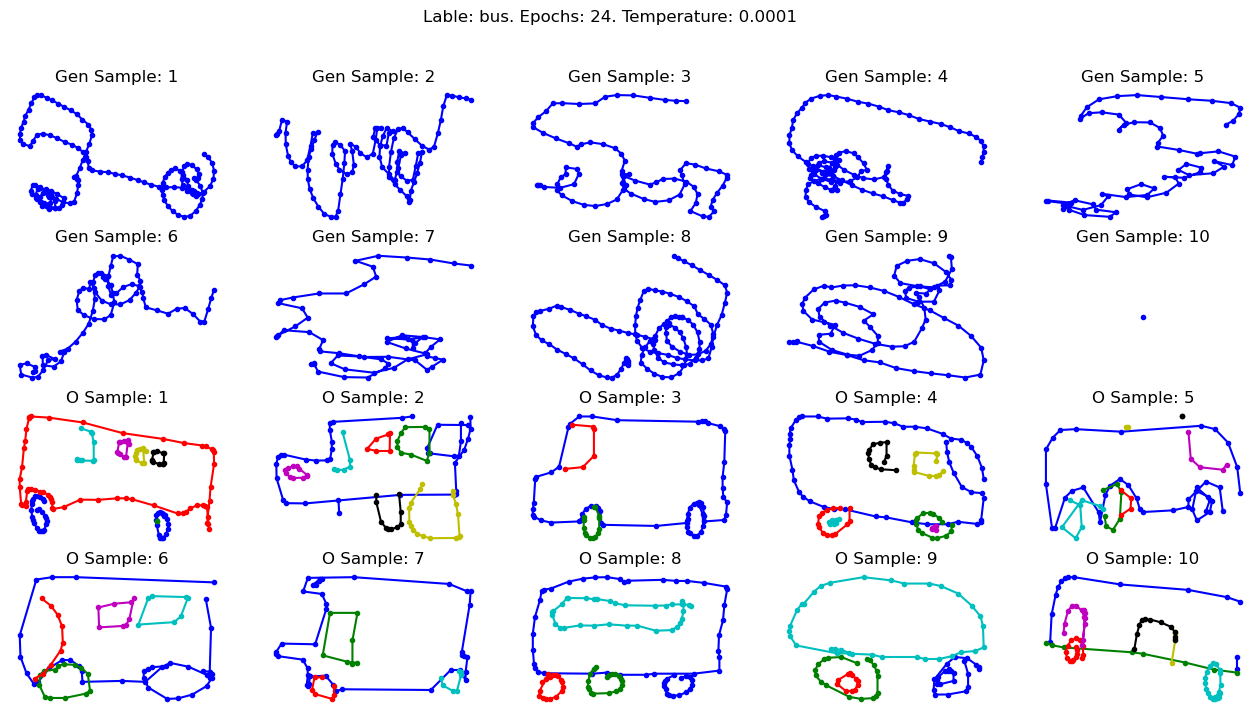

In [ ]:
config.mode = 'test'
config.test_epoch = 24 # 根据实际情况选择
test_model = model(config)

test_model.encoder.load_state_dict(torch.load(f"./saved_model/trained_SRNN_{config.data_lable}_epoch{config.test_epoch}_encoder.pth", map_location=config.device))
test_model.decoder.load_state_dict(torch.load(f"./saved_model/trained_SRNN_{config.data_lable}_epoch{config.test_epoch}_decoder.pth", map_location=config.device))

test_model.test(config, test_data, epoch_now = config.test_epoch)


